In [1]:
%matplotlib inline

In [2]:
import numpy as np
import numpy
import matplotlib.pyplot as plt
import pandas as pd
import math
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, TimeDistributed
from keras.layers import LSTM, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import scipy as scipy
from keras.callbacks import TensorBoard
from keras.regularizers import l1, activity_l1
from keras.regularizers import l2, activity_l2
from sklearn import preprocessing  
from datetime import datetime


Using TensorFlow backend.


In [3]:
numpy.random.seed(7)

In [4]:
df_train = pd.read_csv("../train.csv")
df_test = pd.read_csv("../test.csv")

In [5]:
df_train['month'] = pd.DatetimeIndex(df_train.datetime).month
df_train['day'] = pd.DatetimeIndex(df_train.datetime).dayofweek
df_train['hour'] = pd.DatetimeIndex(df_train.datetime).hour
df_train['year'] = pd.DatetimeIndex(df_train.datetime).year

In [6]:
df_train_train = df_train.drop(['datetime','casual','registered','count'], axis = 1)
df_train_train = df_train_train.drop(['season','workingday','weather','holiday'], axis = 1)
df_test_train = df_train['count']

In [7]:
df_train_train.head()

,temp,atemp,humidity,windspeed,month,day,hour,year
0,9.84,14.395,81,0,1,5,0,2011
1,9.02,13.635,80,0,1,5,1,2011
2,9.02,13.635,80,0,1,5,2,2011
3,9.84,14.395,75,0,1,5,3,2011
4,9.84,14.395,75,0,1,5,4,2011


In [8]:
n = len(df_train_train)
train_x = df_train_train[0:int(n*.8)].astype('float32')
train_y = df_test_train[0:int(n*.8)].astype('float32')
test_x = df_train_train[int(n*.8)+1:n].astype('float32')
test_y = df_test_train[int(n*.8)+1:n].astype('float32')

In [9]:
scaler = MinMaxScaler(feature_range=(-1, 1))

In [10]:
train_x_r = scaler.fit_transform(train_x.values)
#for elem in (train_x,trainY,test_x,testY):
#    for col in range(len(elem.values[0])):
#        print elem.values[col]
#        elem.values[:,col] = scaler.fit_transform(elem.values[:,col])
#trainY = scaler.fit_transform(train_y.values)
test_x_r = scaler.fit_transform(test_x.values)
#testY = scaler.fit_transform(test_y.values)

In [11]:
#simplernn = keras.layers.recurrent.SimpleRNN(64, init='glorot_uniform', inner_init='orthogonal', activation='sigmoid', W_regularizer=None, U_regularizer=None, b_regularizer=None, dropout_W=0.0, dropout_U=0.0)

In [12]:
#trainX = numpy.reshape(train_x_r, (train_x_r.shape[0], 1, train_x_r.shape[1]))
#testX = numpy.reshape(test_x_r, (test_x_r.shape[0], 1, test_x_r.shape[1]))

In [13]:
#model = Sequential()
#model.add(Dense(1, input_shape=(8,)))
#model.add(SimpleRNN(64, input_shape=(8,)))
#model.add(Dense(8))
#model.add(Activation('relu'))

# create model
#model = Sequential()
#model.add(Dense(13, input_dim=8, init='normal', activation='relu'))
#model.add(Dense(1, init='normal'))
# Compile model
#model.compile(loss='mean_squared_error', optimizer='adam')

#model = Sequential()
#model.add(Dense(1, input_shape=(8,) ))
#model.add(Activation('relu'))
#model.add(LSTM(2, input_shape=(1, 8)))


#model.compile(loss='mean_squared_error', optimizer='adam')
#model.fit(trainX, trainY, nb_epoch=10, batch_size=32,verbose=1)


In [14]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
import numpy as np

data_dim = len(train_x_r[0])
timesteps = 1

# expected input data shape: (batch_size, timesteps, data_dim)
model = Sequential()
#model.add(Dense(100))
model.add(LSTM(100, return_sequences=True,
               input_shape=(timesteps, data_dim) )) #W_regularizer=l2(0.01) 
model.add(LSTM(100, return_sequences=True)) #, W_regularizer=l2(0.01)
model.add(LSTM(10))  
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error',
              optimizer='rmsprop')

# generate dummy training data
def resizetimestep(dataset,timestepsize):
    return dataset[0:int(len(dataset/timestepsize))]

train_x_r = resizetimestep(train_x_r,timesteps)
test_x_r =  resizetimestep(test_x_r,timesteps)

x_train = numpy.reshape(train_x_r, (train_x_r.shape[0]/timesteps, timesteps, train_x_r.shape[1]))
y_train = scaler.fit_transform(train_y.values)


x_val = numpy.reshape(test_x_r, (test_x_r.shape[0]/timesteps, timesteps, test_x_r.shape[1]))
y_val = scaler.fit_transform(test_y.values)
# generate dummy validation data

now = datetime.now()

model.fit(x_train, y_train,
          batch_size=20, nb_epoch=100,
          validation_data=(x_val, y_val),callbacks=[TensorBoard(log_dir='logs/' + now.strftime("%Y%m%d-%H%M%S") + "/")])

Train on 8708 samples, validate on 2177 samples
Epoch 1/100
8708/8708 [==============================] - 55s - loss: 0.0991 - val_loss: 0.1674
Epoch 2/100
8708/8708 [==============================] - 43s - loss: 0.0682 - val_loss: 0.1781
Epoch 3/100
8708/8708 [==============================] - 51s - loss: 0.0599 - val_loss: 0.1606
Epoch 4/100
8708/8708 [==============================] - 42s - loss: 0.0563 - val_loss: 0.1696
Epoch 5/100
8708/8708 [==============================] - 42s - loss: 0.0547 - val_loss: 0.1377
Epoch 6/100
8708/8708 [==============================] - 46s - loss: 0.0531 - val_loss: 0.1513
Epoch 7/100
8708/8708 [==============================] - 44s - loss: 0.0511 - val_loss: 0.1502
Epoch 8/100
8708/8708 [==============================] - 43s - loss: 0.0485 - val_loss: 0.1359
Epoch 9/100
8708/8708 [==============================] - 49s - loss: 0.0424 - val_loss: 0.1334
Epoch 10/100
8708/8708 [==============================] - 42s - loss: 0.0339 - val_loss: 0.1323
E

/usr/local/bin/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/bin/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/bin/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if

In [15]:
trainPredict = model.predict(x_train)
testPredict = model.predict(x_val)
trainPredict = scaler.inverse_transform(trainPredict)
train_y_r_e = scaler.inverse_transform(y_train)
testPredict = scaler.inverse_transform(testPredict)
test_y_r_e = y_val#scaler.inverse_transform([y_val])

/usr/local/bin/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


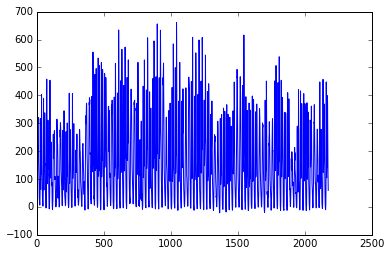

In [16]:
plt.plot(testPredict)

In [17]:
trainScore = math.sqrt(mean_squared_error(train_y_r_e, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(test_y_r_e, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 36.78 RMSE
Test Score: 201.24 RMSE


0.98012


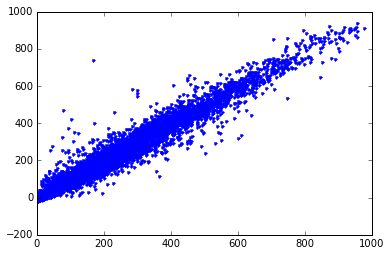

In [18]:
print scipy.stats.pearsonr(train_y_r_e,trainPredict[:,0])[0]
plt.plot(train_y_r_e,trainPredict,'.')

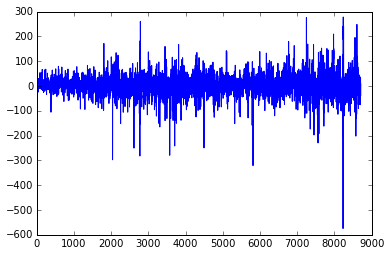

In [19]:
plt.plot(train_y_r_e-trainPredict[:,0])

In [20]:
a=train_y_r_e-trainPredict
a[a<-500]

array([-510.17501831, -510.17501831, -509.07839966, ..., -500.42730713,
       -500.42730713, -500.42730713], dtype=float32)

0.908973


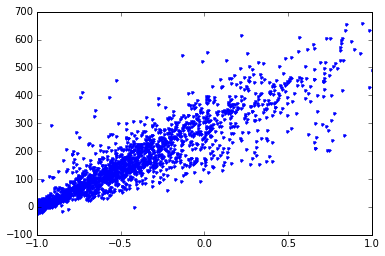

In [21]:
print scipy.stats.pearsonr(test_y_r_e,testPredict[:,0])[0]
plt.plot(test_y_r_e,testPredict,'.')

In [22]:
df_test['month'] = pd.DatetimeIndex(df_test.datetime).month
df_test['day'] = pd.DatetimeIndex(df_test.datetime).dayofweek
df_test['hour'] = pd.DatetimeIndex(df_test.datetime).hour
df_test['year'] = pd.DatetimeIndex(df_test.datetime).year
df_test_test = df_test.drop(['datetime'], axis = 1)
df_test_test = df_test_test.drop(['season','workingday','weather','holiday'], axis = 1)
df_test_t = scaler.fit_transform(df_test_test.values)
df_test_r = numpy.reshape(df_test_t, (df_test_t.shape[0], timesteps , df_test_t.shape[1]))
pred = model.predict(df_test_r)

In [23]:
scaler.fit_transform(test_y.values)

/usr/local/bin/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/bin/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


array([-0.9631148 , -0.86270493, -0.78073776, ..., -0.65778697,
       -0.73770499, -0.82172132], dtype=float32)

In [24]:
out = scaler.inverse_transform(pred).astype(int)
out[out<0] = 0
out = out[:,0]

In [25]:
pred = pd.DataFrame({'datetime': df_test['datetime'],'count': out})
pred = pred[['datetime','count']]

In [26]:
pred.to_csv("pred.csv", index = False)

In [27]:
predicted = pd.read_csv('pred.csv')

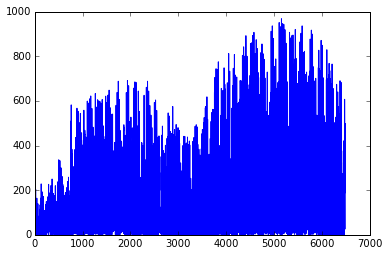

In [28]:
plt.plot(predicted['count'])

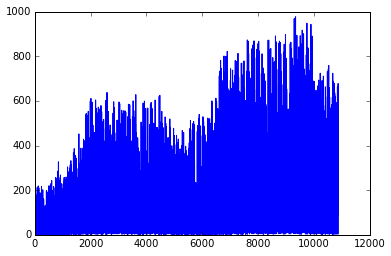

In [29]:
plt.plot(df_train['count'].values)

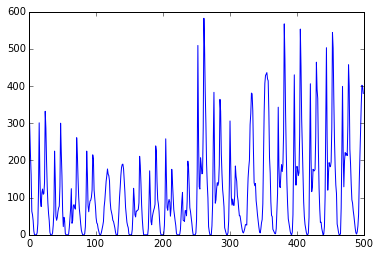

In [30]:
plt.plot(predicted['count'][500:1000])